# 01 — Synthetic Data & Baselines

This notebooks does the following:
1) Generate synthetic temperature data with **spikes**, **drops**, **drift**, and **noisy** segments.
2) Explore rolling stats and a simple z-score detector.
3) Build a small **Isolation Forest** baseline.


In [19]:
## run this if noticing trouble with library imports
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print("Using project root:", PROJECT_ROOT)


Using project root: /Users/rafayshahzad/Desktop/Projects/temperature-anomaly-detection


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, classification_report
from src.sim import simulate_temperature_series
from src.features import add_rolling_features, make_windowed_matrix

pd.set_option("display.max_columns", 50)

## 1) Generate synthetic data

In [21]:
df = simulate_temperature_series(n=10000, base_temp=100.0, noise_sigma=0.2, seed=42)
df.head()

,t,temp,is_anomaly,anomaly_type
0,0,100.060943,False,none
1,1,99.792003,False,none
2,2,100.150090,False,none
3,3,100.188113,False,none
4,4,99.609793,False,none


### Plot the temperature series

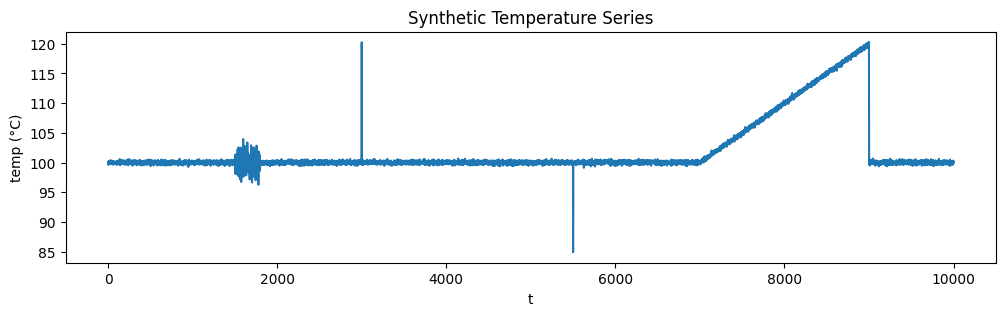

In [22]:
plt.figure(figsize=(12,3))
plt.plot(df['t'], df['temp'])
plt.title('Synthetic Temperature Series')
plt.xlabel('t'); plt.ylabel('temp (°C)')
plt.show()

## 2) Rolling stats + z-score detector

In [23]:
window = 50
df = add_rolling_features(df, window=window)

# Simple rule-based anomaly via rolling z-score threshold
THRESH = 4.0
df['anomaly_rule'] = (df[f'zscore_{window}'].abs() >= THRESH).astype(int)

y_true = df['is_anomaly'].astype(int).fillna(0).values
y_pred = df['anomaly_rule'].values

# Some roll features are NaN at the beginning; ignore those indices
valid = ~np.isnan(df[f'zscore_{window}'].values)
pr, rc, f1, _ = precision_recall_fscore_support(y_true[valid], y_pred[valid], average='binary', zero_division=0)
print(f"Rule-based z-score >= {THRESH}: Precision={pr:.3f} Recall={rc:.3f} F1={f1:.3f}")

Rule-based z-score >= 4.0: Precision=0.500 Recall=0.001 F1=0.003


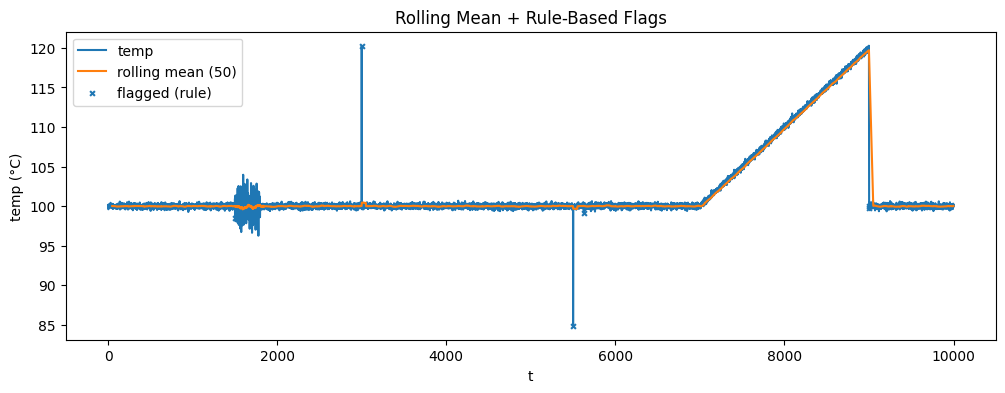

In [24]:
# Visualize z-score and flagged anomalies
plt.figure(figsize=(12,4))
plt.plot(df['t'], df['temp'], label='temp')
plt.plot(df['t'], df[f'roll_mean_{window}'], label=f'rolling mean ({window})')
plt.scatter(df.loc[df['anomaly_rule']==1, 't'],
            df.loc[df['anomaly_rule']==1, 'temp'],
            s=12, label='flagged (rule)', marker='x')
plt.legend()
plt.title('Rolling Mean + Rule-Based Flags')
plt.xlabel('t'); plt.ylabel('temp (°C)')
plt.show()

## 3) Isolation Forest on windowed slices

In [25]:
win = 50
X = make_windowed_matrix(df['temp'].values, window=win)

# IsolationForest expects 2D features; here each row is a short window of the series.
iso = IsolationForest(
    n_estimators=200,
    contamination=0.03,  # expected anomaly fraction; tune later
    random_state=42
)
iso.fit(X)

# Scores: -1 = anomaly, 1 = normal
preds = iso.predict(X)

# Expand back to series length by aligning window centers
anom_iso = np.zeros(len(df), dtype=int)
centers = np.arange(win//2, len(df) - win//2 + 1)  # +1 to include the last center
anom_iso[centers] = (preds == -1).astype(int)

df['anomaly_iso'] = anom_iso

# Evaluate
y_true = df['is_anomaly'].astype(int).values
y_pred = df['anomaly_iso'].values
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.792     0.999     0.884      7698
           1      0.963     0.125     0.221      2302

    accuracy                          0.797     10000
   macro avg      0.878     0.562     0.553     10000
weighted avg      0.832     0.797     0.731     10000



### Plot Isolation Forest flags

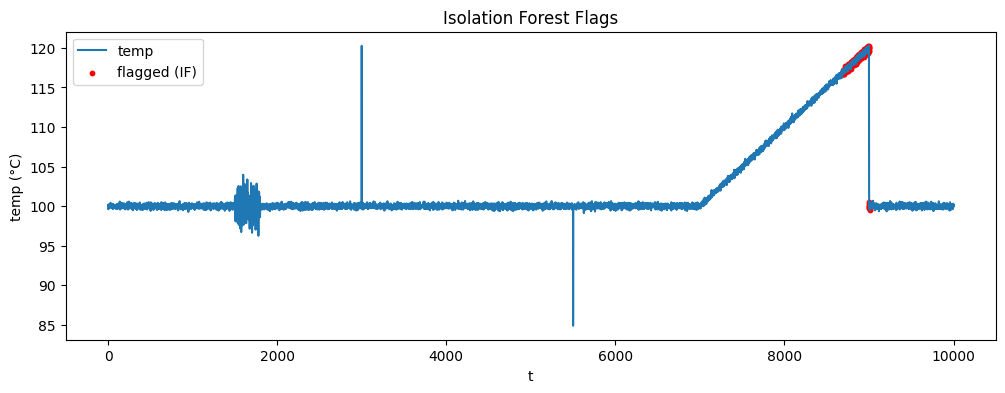

In [26]:
plt.figure(figsize=(12,4))
plt.plot(df['t'], df['temp'], label='temp')
plt.scatter(df.loc[df['anomaly_iso']==1, 't'],
            df.loc[df['anomaly_iso']==1, 'temp'],
            s=10, label='flagged (IF)', marker='o', color="red")
plt.legend()
plt.title('Isolation Forest Flags')
plt.xlabel('t'); plt.ylabel('temp (°C)')
plt.show()

## 4) Save artifacts (optional)

In [27]:
import os

out_dir = "../data/processed"  
os.makedirs(out_dir, exist_ok=True)

out_csv = os.path.join(out_dir, "simulated_with_flags.csv")
df.to_csv(out_csv, index=False)
print(f"Saved to {out_csv}")



Saved to ../data/processed/simulated_with_flags.csv


---
**Next up (covered in later notebooks):**
- Hyperparameter tuning & threshold calibration.
- Drift detection (slow trends).
- Simple streaming monitor that buffers the last N points and scores in real time.
